## Домашнее задание: "Детекция объектов на изображении"

ФИО: Семенников Макар Алексеевич

## Цель задания:
Научиться самостоятельно решать задачу детекции.
## Описание задания:
В рамках данного домашнего задания предлагается решить задачу детекции мячей и настроить полный пайплайн обучения модели. 

Процесс выполнения задания следующий:

0. Выбор модели детекции для обучения:
    1. Выберите модель детекции для выполнения домашнего задания. Любую, кроме RetinaNet. Ее реализацию можно взять из открытых источников. Модель можно брать предобученную ( в этом случае в пункте 4. показать влияние предобучения на финальное качество). 
    2. Полезные ссылки: [PyTorch Vision Models](https://pytorch.org/vision/stable/models.html) (блок Object Detection), [SOTA модели детекции](https://paperswithcode.com/sota/object-detection-on-coco), [Возможный пример кода](https://github.com/AlekseySpasenov/dl-course/blob/autumn_2023/lecture8/detection_example/pytorch_detection_workshop.ipynb)

1. Подготовка обучающего набора данных
    1. Реализуйте корректный класс Dataset и Dataloader для выбранной модели (должен работать форвард вашей модели на том, что выходит из даталоадера) **0.5 балла**.
    2. Добавьте простые аугментации в датасет (аугментации, не затрагивающие изменение ground-truth bounding box) **0.5 балла**.
    3. Внедрите сложные аугментации (аугментации, затрагивающие изменение ground-truth bounding box. Например, аффинные преобразования: сдвиг, поворот и т.д.) **0.5 балла**.

    4. Полезные ссылки: https://pytorch.org/vision/stable/transforms.html , https://albumentations.ai

2. Реализация корректного train-loop и обучение модели:  
    1. Реализуйте эффективный train-loop для вашей модели и проведите обучение **2 балла**.
    2. Выполните несколько запусков обучения с различными параметрами, например: сравните влияние различных аугментаций, оцените влияние того была предобучена модель или нет, сравните результаты при изменении гиперпараметров итд (на ваш выбор) **0.5 балла**.
 
3. Валидация обученных моделей на тестовой выборке, вычисление метрики mAP
    1. Оцените качество моделей на тестовой части данных и рассчитайте метрику mAP **0.5 балл**
    2. Полезные ссылки: [mean_average_precision](https://github.com/bes-dev/mean_average_precision)

4. Выводы **0.5 балл**:
    1. Проанализируйте результаты обучения, визуально оцените качество работы модели.
    2. Прокомментируйте распространенные ошибки модели и предложите пути для улучшения финального решения.

### 1. Возьму архитектуру Faster-RCNN из torch

### 2. Доработаю DetectionDataset с семинара так, чтобы он выдавал данные, которые принимает FasterRCNN.

In [1]:
import torch.utils.data
import json
from torchvision import transforms
import matplotlib.patches as patches
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import math
import sys
from mean_average_precision import MetricBuilder
import matplotlib.pyplot as plt
import torch
import numpy as np

C:\Users\zacgr\Documents\GitReps\technopark\NN\.venv_nn\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.19 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
class DetectionDataset(torch.utils.data.Dataset):
    def __init__(self, data_dict_file, transforms=None, add_path=None):
        with open(data_dict_file, 'r') as f:
            self.data_dict = json.load(f)
        if add_path:
            self.data_dict = {os.path.join(add_path, k): v for k, v in self.data_dict.items()}
        self.imgs = list(self.data_dict.keys())
        self.transforms = transforms
        
        
    def __getitem__(self, idx):
        # load images ad masks
        img_path = self.imgs[idx]
        img = Image.open(img_path).convert("RGB")
        w, h = img.size

        num_objs = len(self.data_dict[img_path])
        boxes = []
        for i in range(num_objs):
            bbox = self.data_dict[img_path][i]
            xmin = bbox[0] * w
            xmax = bbox[1] * w
            ymin = bbox[2] * h
            ymax = bbox[3] * h
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        
        image_id = torch.tensor([idx])
    
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target
    
    def __len__(self):
        return len(self.imgs)

In [3]:
img_transforms = transforms.Compose([
    transforms.ToTensor()
])

In [4]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [5]:
train_dataset = DetectionDataset(data_dict_file="./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_train.json",
    add_path='./seminar_objdet_retina_oi5_ball/', transforms=img_transforms)

In [6]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=True, drop_last=True, collate_fn=collate_fn)

In [7]:
def visualize_sample(image, target):
    """
    Визуализирует изображение с bounding boxes.

    Параметры:
    - image: Тензор или numpy-массив изображения.
    - target: Словарь с метками, включая 'boxes' (bounding boxes).
    """

    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()

    fig, ax = plt.subplots(1, figsize=(12, 8))

    ax.imshow(image)

    boxes = target["boxes"].numpy() if isinstance(target["boxes"], torch.Tensor) else target["boxes"]

    for box in boxes:
        xmin, ymin, xmax, ymax = box
        width = xmax - xmin
        height = ymax - ymin

        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()

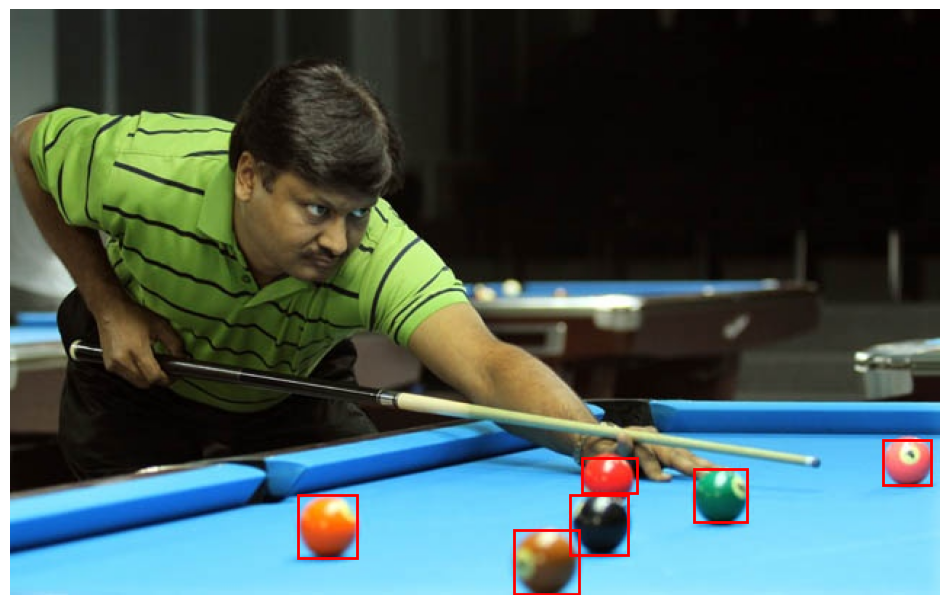

In [8]:
image, target = train_dataset[0]  # Получаем первое изображение и метки
visualize_sample(image, target)

### Импортируем модель  
И настраиваем её обучение

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [10]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=True)

num_classes = 2
in_channels = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_channels = in_channels, num_classes = 2)

C:\Users\zacgr\Documents\GitReps\technopark\NN\.venv_nn\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\zacgr\Documents\GitReps\technopark\NN\.venv_nn\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\zacgr\Documents\GitReps\technopark\NN\.venv_nn\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
C:\Users\zacg

In [11]:
assert model.roi_heads.box_predictor.cls_score.in_features == 1024
assert model.roi_heads.box_predictor.cls_score.out_features == 2
assert model.roi_heads.box_predictor.bbox_pred.out_features == 8

In [12]:
for param in model.parameters():
    param.requires_grad = True
for param in model.roi_heads.box_predictor.parameters():
    param.requires_grad = True
    
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

In [13]:
model.to(device);

Функция обучения модели на одной эпохе

In [14]:
from tqdm import notebook
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    loss_value = None
    for images, targets in notebook.tqdm(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        try: # Тут есть нюанс, после трансформации с картинки может исчезать область с мячиком, поэтому просто пропускаем этот батч, если он появится
            loss_dict = model(images, targets)
            losses = sum([value for value in loss_dict.values()])
            loss_value = losses.item()
            
            if not math.isfinite(loss_value):
                print("Loss is {}, stopping training".format(loss_value))
                # print(loss_dict_reduced)
                sys.exit(1)
                
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
        except Exception as e:
            print(f"Ошибка: {e}. Пропускаем данный батч.")
            continue

    print(loss_value)


Обучим на 2 эпохах, как показали эксперименты много эпох = переобучение

In [15]:
num_epochs=2
for epoch in notebook.tqdm(range(num_epochs)):
    train_one_epoch(model, optimizer, train_loader, device)

C:\Users\zacgr\AppData\Local\Temp\ipykernel_13188\214153726.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(num_epochs)):


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1437 [00:00<?, ?it/s]

0.4139428734779358


  0%|          | 0/1437 [00:00<?, ?it/s]

0.2529139518737793


Оценим качество обучения с помощью MAP

In [16]:
def calculate_map(model, dataloader, iou_threshold=0.5, device='cuda'):
    metric = MetricBuilder.build_evaluation_metric("map_2d", async_mode=False, num_classes=2)

    model.to(device)
    model.eval()

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for target, output in zip(targets, outputs):
                gt_boxes = target["boxes"].cpu().numpy()
                gt_labels = target["labels"].cpu().numpy()

                pred_boxes = output["boxes"].cpu().numpy()
                pred_labels = output["labels"].cpu().numpy()
                pred_scores = output["scores"].cpu().numpy()

                gt = np.hstack([gt_boxes, gt_labels[:, None], np.zeros((len(gt_labels), 2))])
                preds = np.hstack([pred_boxes, pred_labels[:, None], pred_scores[:, None]])

                metric.add(preds, gt)

    metrics_result = metric.value(iou_thresholds=iou_threshold)
    print(f"mAP: {metrics_result['mAP']}")

    return metrics_result

Загрузим валидационную выборку

In [17]:
val_dataset = DetectionDataset(data_dict_file="./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_val.json",
    add_path='./seminar_objdet_retina_oi5_ball/', transforms=img_transforms)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=2, shuffle=False, drop_last=False, collate_fn=collate_fn)

Посмотрим на значение метрики

In [18]:
# Пример использования:
calculate_map(model, val_loader)

C:\Users\zacgr\Documents\GitReps\technopark\NN\.venv_nn\Lib\site-packages\mean_average_precision\mean_average_precision_2d.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.match_table[c] = pd.concat([self.match_table[c], match_table], axis=0, join='outer')


mAP: 0.3866100609302521


{0.5: {0: {'ap': np.float32(0.0),
   'precision': array([], dtype=float64),
   'recall': array([], dtype=float64)},
  1: {'ap': np.float32(0.7732201),
   'precision': array([1.        , 1.        , 1.        , ..., 0.27725857, 0.27708593,
          0.2769135 ]),
   'recall': array([0.00203666, 0.00407332, 0.00610998, ..., 0.90631365, 0.90631365,
          0.90631365])}},
 'mAP': np.float32(0.38661006)}

### Визуализируем предсказание модели на случайной картинке

In [19]:
def visualize_prediction(img_path, model, device, threshold=0.5, transforms=None):
    model.eval()
    
    image = np.array(Image.open(img_path).convert("RGB"))
    
    if transforms is None:
        transforms = A.Compose([ToTensorV2()])
    img_tensor = transforms(image=image)["image"].unsqueeze(0)  # [1, 3, H, W]

    img_tensor = img_tensor.float() / 255.0
    img_tensor = img_tensor.to(device)

    with torch.no_grad():
        prediction = model(img_tensor)[0]

    plt.imshow(image)
    ax = plt.gca()

    for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
        if score >= threshold:
            xmin, ymin, xmax, ymax = box.cpu().numpy()
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                       fill=False, color='red', linewidth=2))
    plt.axis('off')
    plt.show()


In [ ]:
val_dict = json.load(open("./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_val.json"))
val_filenames = list(val_dict.keys())

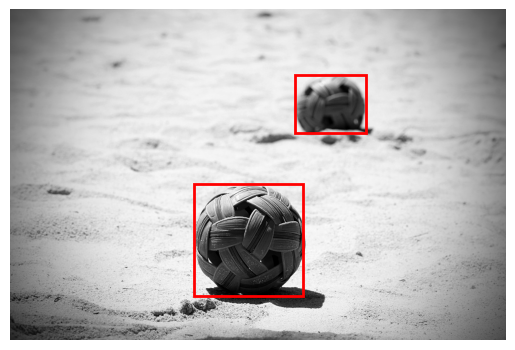

In [53]:
filename = np.random.choice(val_filenames)
filename = f'seminar_objdet_retina_oi5_ball/{filename}'
visualize_prediction(filename, model, device=device)

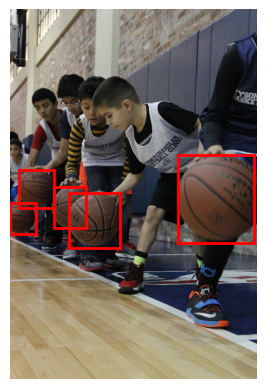

In [51]:
filename = np.random.choice(val_filenames)
filename = f'seminar_objdet_retina_oi5_ball/{filename}'
visualize_prediction(filename, model, device=device)

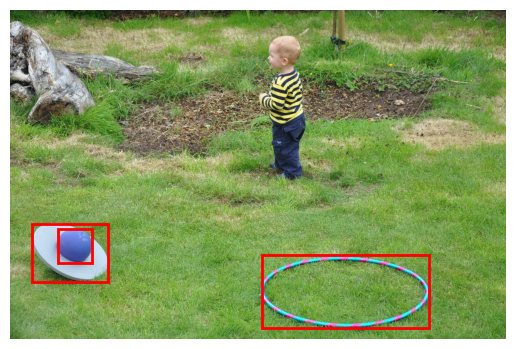

In [65]:
filename = np.random.choice(val_filenames)
filename = f'seminar_objdet_retina_oi5_ball/{filename}'
visualize_prediction(filename, model, device=device)

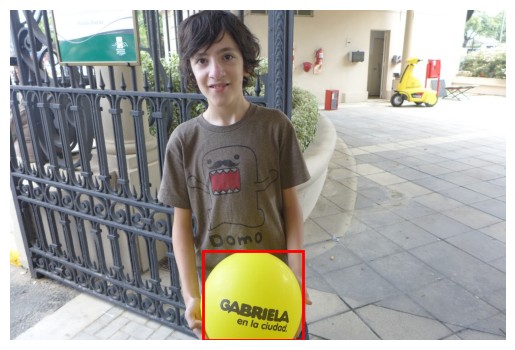

In [54]:
filename = np.random.choice(val_filenames)
filename = f'seminar_objdet_retina_oi5_ball/{filename}'
visualize_prediction(filename, model, device=device)

Видно, что модель в принципе справляется со своей задачей. Конечно ошибки присутствуют

#### Теперь попробуем добавить аугментаций, для этого обновим класс датасета

In [23]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import json

# Композиция аугментаций с учетом bbox
# Здесь и "простые" и "сложные" аугментации
train_transforms_2 = A.Compose([
    A.HorizontalFlip(p=0.5),  # Отражение
    A.RandomBrightnessContrast(p=0.2),  # Яркость/контраст
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),  # Сдвиг, масштаб, поворот
    A.Normalize(mean=(0.5, 0.5, 0.5)),  # Нормализация
    ToTensorV2()  # Преобразование в тензор
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'], min_visibility=0.1))

class DetectionDataset(torch.utils.data.Dataset):
    def __init__(self, data_dict_file, transforms=None, add_path=None):
        with open(data_dict_file, 'r') as f:
            self.data_dict = json.load(f)
        if add_path:
            self.data_dict = {os.path.join(add_path, k): v for k, v in self.data_dict.items()}
        self.imgs = list(self.data_dict.keys())
        self.transforms = transforms
        
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = Image.open(img_path).convert("RGB")
        w, h = img.size

        num_objs = len(self.data_dict[img_path])
        boxes = []
        for i in range(num_objs):
            bbox = self.data_dict[img_path][i]
            xmin = bbox[0] * w
            xmax = bbox[1] * w
            ymin = bbox[2] * h
            ymax = bbox[3] * h
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32).tolist()
        labels = [1] * num_objs 

        target = {
            "boxes": boxes,
            "labels": labels
        }

        img_np = np.array(img)

        if self.transforms is not None:
            transformed = self.transforms(image=img_np, bboxes=target["boxes"], labels=target["labels"])
            img = transformed["image"]
            target["boxes"] = transformed["bboxes"]
            target["labels"] = transformed["labels"]

        target["boxes"] = torch.tensor(target["boxes"], dtype=torch.float32)
        target["labels"] = torch.tensor(target["labels"], dtype=torch.int64)

        return img, target

    def __len__(self):
        return len(self.imgs)


In [24]:
train_dataset_aug = DetectionDataset(data_dict_file="./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_train.json",
    add_path='./seminar_objdet_retina_oi5_ball/', transforms=train_transforms_2)

In [25]:
train_loader_aug = torch.utils.data.DataLoader(
    train_dataset_aug, batch_size=2, shuffle=True, drop_last=True, collate_fn=collate_fn)

Посмотрим, что изменилось на том же изображении

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2321427..2.2321427].


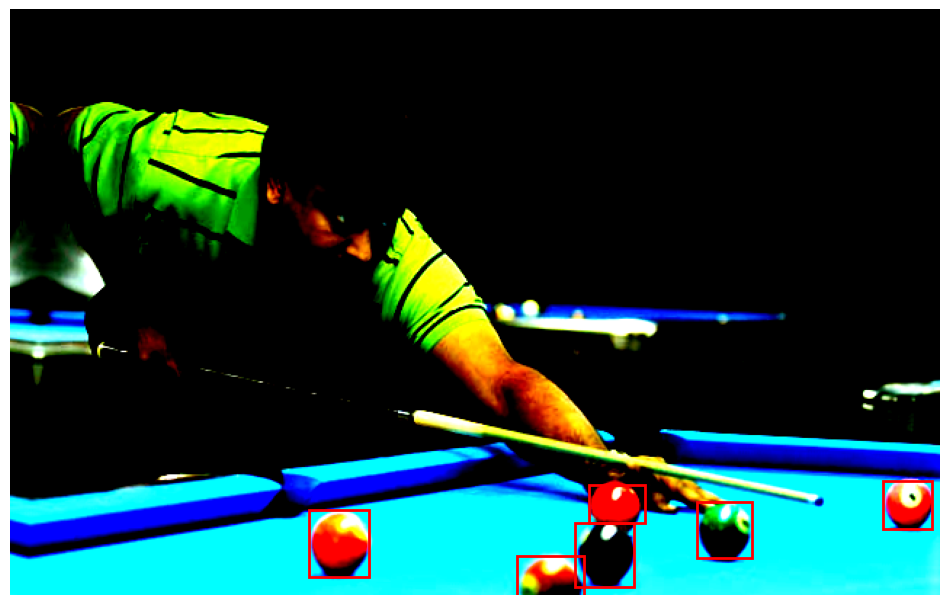

In [26]:
image, target = train_dataset_aug[0]
visualize_sample(image, target)

Объявим новую модель и обучим её

In [27]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model_aug = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=True)

num_classes = 2
in_channels = model_aug.roi_heads.box_predictor.cls_score.in_features
model_aug.roi_heads.box_predictor = FastRCNNPredictor(in_channels = in_channels, num_classes = 2)

C:\Users\zacgr\Documents\GitReps\technopark\NN\.venv_nn\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\zacgr\Documents\GitReps\technopark\NN\.venv_nn\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\zacgr\Documents\GitReps\technopark\NN\.venv_nn\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
C:\Users\zacg

In [28]:
assert model_aug.roi_heads.box_predictor.cls_score.in_features == 1024
assert model_aug.roi_heads.box_predictor.cls_score.out_features == 2
assert model_aug.roi_heads.box_predictor.bbox_pred.out_features == 8

In [29]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


for param in model_aug.parameters():
    param.requires_grad = True
for param in model_aug.roi_heads.box_predictor.parameters():
    param.requires_grad = True
    
params = [p for p in model_aug.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

In [30]:
model_aug.to(device);

In [31]:
num_epochs=2
for epoch in notebook.tqdm(range(num_epochs)):
    train_one_epoch(model_aug, optimizer, train_loader_aug, device)

C:\Users\zacgr\AppData\Local\Temp\ipykernel_13188\3116255909.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(num_epochs)):


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1437 [00:00<?, ?it/s]

Ошибка: Expected target boxes to be a tensor of shape [N, 4], got torch.Size([0]).. Пропускаем данный батч.
Ошибка: Expected target boxes to be a tensor of shape [N, 4], got torch.Size([0]).. Пропускаем данный батч.
Ошибка: Expected target boxes to be a tensor of shape [N, 4], got torch.Size([0]).. Пропускаем данный батч.
Ошибка: Expected target boxes to be a tensor of shape [N, 4], got torch.Size([0]).. Пропускаем данный батч.
Ошибка: Expected target boxes to be a tensor of shape [N, 4], got torch.Size([0]).. Пропускаем данный батч.
Ошибка: Expected target boxes to be a tensor of shape [N, 4], got torch.Size([0]).. Пропускаем данный батч.
Ошибка: Expected target boxes to be a tensor of shape [N, 4], got torch.Size([0]).. Пропускаем данный батч.
Ошибка: Expected target boxes to be a tensor of shape [N, 4], got torch.Size([0]).. Пропускаем данный батч.
0.1429925262928009


  0%|          | 0/1437 [00:00<?, ?it/s]

Ошибка: Expected target boxes to be a tensor of shape [N, 4], got torch.Size([0]).. Пропускаем данный батч.
Ошибка: Expected target boxes to be a tensor of shape [N, 4], got torch.Size([0]).. Пропускаем данный батч.
Ошибка: Expected target boxes to be a tensor of shape [N, 4], got torch.Size([0]).. Пропускаем данный батч.
Ошибка: Expected target boxes to be a tensor of shape [N, 4], got torch.Size([0]).. Пропускаем данный батч.
0.0726023018360138


Посмотрим на MAP метрику

In [69]:
val_transforms_aug = A.Compose([
    A.Normalize(mean=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

In [70]:
val_dataset_aug = DetectionDataset(data_dict_file="./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_val.json",
    add_path='./seminar_objdet_retina_oi5_ball/', transforms=val_transforms_aug)

val_loader_aug = torch.utils.data.DataLoader(
    val_dataset, batch_size=2, shuffle=False, drop_last=False, collate_fn=collate_fn)

In [71]:
calculate_map(model_aug, val_loader_aug)

C:\Users\zacgr\Documents\GitReps\technopark\NN\.venv_nn\Lib\site-packages\mean_average_precision\mean_average_precision_2d.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.match_table[c] = pd.concat([self.match_table[c], match_table], axis=0, join='outer')


mAP: 0.3263925313949585


{0.5: {0: {'ap': np.float32(0.0),
   'precision': array([], dtype=float64),
   'recall': array([], dtype=float64)},
  1: {'ap': np.float32(0.65278506),
   'precision': array([1.        , 1.        , 1.        , ..., 0.23059743, 0.23046875,
          0.23034021]),
   'recall': array([0.00203666, 0.00407332, 0.00610998, ..., 0.84114053, 0.84114053,
          0.84114053])}},
 'mAP': np.float32(0.32639253)}

Видим небольшое ухудшение качества

Также посмотрим на случайное предсказание из валидационной выборки

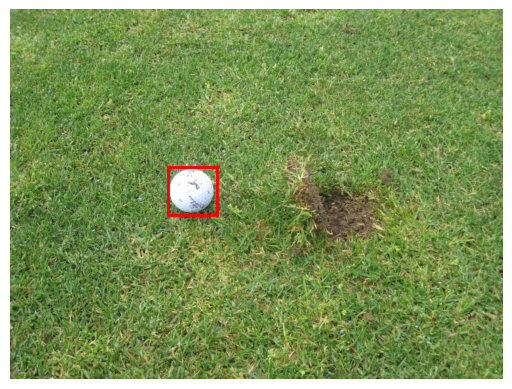

In [55]:
filename = np.random.choice(val_filenames)
filename = f'seminar_objdet_retina_oi5_ball/{filename}'
visualize_prediction(filename, model_aug, transforms=val_transforms_aug, device=device, threshold=0.3)

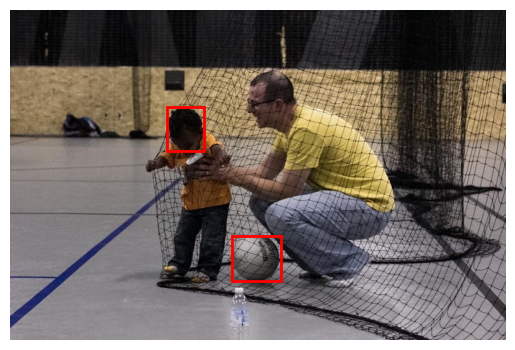

In [68]:
filename = np.random.choice(val_filenames)
filename = f'seminar_objdet_retina_oi5_ball/{filename}'
visualize_prediction(filename, model_aug, transforms=val_transforms_aug, device=device, threshold=0.3)

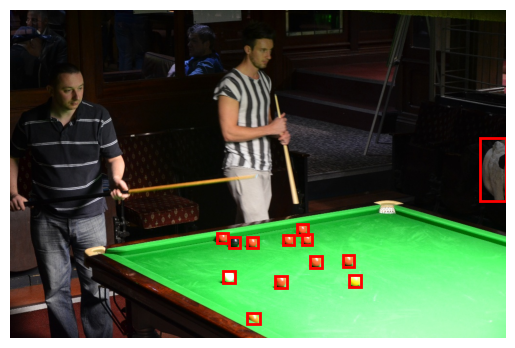

In [57]:
filename = np.random.choice(val_filenames)
filename = f'seminar_objdet_retina_oi5_ball/{filename}'
visualize_prediction(filename, model_aug, transforms=val_transforms_aug, device=device, threshold=0.3)

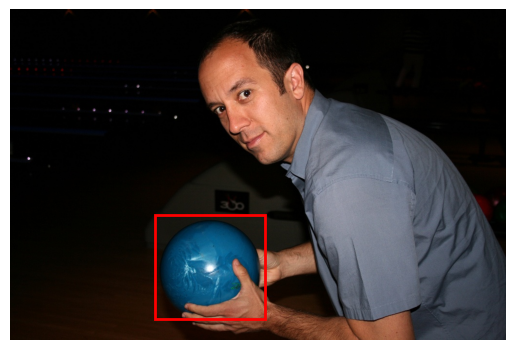

In [63]:
filename = np.random.choice(val_filenames)
filename = f'seminar_objdet_retina_oi5_ball/{filename}'
visualize_prediction(filename, model_aug, transforms=val_transforms_aug, device=device, threshold=0.3)

Если смотреть человеческим взглядом, то в большинстве случаев мячики определяются верно.

### Выводы  

Применение аугментаций к обучающему датасету принесло скорее негативный результат, модель работает хуже. Хотя есть вероятность того, что если "поиграться" с количеством эпох, то модель обученная на аугментированных данных может показать лучший результат.  
Также в общем для задачи детекции можно сделать вывод, что невооружённым взглядом (в отличии от задачи классификации) сложно констатировать степень ошибки модели в случаях, когда она не слишком грубая.